In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import json
import os
import openai
from dotenv import load_dotenv, find_dotenv


# Get the current working directory
notebook_dir = os.getcwd()
print(notebook_dir)
project_dir = os.path.dirname(notebook_dir)
print(project_dir)

sys.path.append(project_dir)

from evaluation import *
from data_preparation import *

/Users/pierre.krzisch/dev/perso/projects/handoff-eval/notebooks
/Users/pierre.krzisch/dev/perso/projects/handoff-eval


# Load data

In [5]:
_ = load_dotenv(find_dotenv())  # read local .env file

data_path = "../data/ai_ml_take_home"
ground_truth_path = os.path.join(data_path, "ground_truth")
model_outputs_path = os.path.join(data_path, "model_outputs")

In [6]:
file_path = os.path.join(ground_truth_path, "example_01.json")
# Load JSON file
with open(file_path, "r", encoding="utf-8") as file:
    example_01 = json.load(file)

file_path = os.path.join(model_outputs_path, "2.json")
# Load JSON file
with open(file_path, "r", encoding="utf-8") as file:
    output_02 = json.load(file)

# Print or inspect the data
print(json.dumps(example_01, indent=4, ensure_ascii=False))

{
    "test_n": 1,
    "input": "Bathroom Remodel project: 7'x10'-6\", 8 ft ceilings\nDemo a tub/shower combo\nReplace with a complete shower system, with tiled walls, niche, and curb.\nReplace tile floor with new tile.\nNew double vanity.\nNew Toilet.\nPlumbing fixtures stay in place, no relocation or new rough-in needed.\nRepaint whole room 3 coats.\nReplace 4 light fixtures.\nShower Glass Enclosure excluded.",
    "rows": [
        {
            "sectionName": "Demolition",
            "qty": 66.0,
            "rateUsd": 2.4,
            "rowTotalCostUsd": 158.4,
            "label": "Demo Shower Surround",
            "uom": "SF",
            "category": "other"
        },
        {
            "sectionName": "Demolition",
            "qty": 1.0,
            "rateUsd": 80.0,
            "rowTotalCostUsd": 80.0,
            "label": "Demo Vanity",
            "uom": "EA",
            "category": "other"
        },
        {
            "sectionName": "Demolition",
            "qty":

In [7]:
# print("\n\n\n-----------------------\n\n\n")
# print(json.dumps(output_02, indent=4, ensure_ascii=False))

In [8]:
len(example_01["rows"])

22

In [9]:
len(output_02["estimate_preds"][0]["rows"])

29

In [10]:
ground_truth_data = load_json_files(ground_truth_path)
model_output_data = load_json_files(model_outputs_path)

# Reverse engineering

to find how they used LLM to extract line-items estimations from a simple description (is it possible)?

- they use the input (description of the project with details and requirements)
- and a prompt to generate the estimated list of line-items

In [11]:
import openai
import json
import re

def get_line_items(description):
    prompt = f"""
    Given the following bathroom remodel project description, \
    generate a structured list of line items with quantities, unit rates, and total costs.
    
    Description:
    {description}
    
    Expected output:
    - A JSON object with a "rows" array containing structured cost estimates.
    - Each row should have: sectionName, qty, rateUsd, rowTotalCostUsd, label, uom, and category.
    - Use common industry rates for cost estimation.
    """

    response = openai.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": "You are a construction cost estimator",
            },
            {"role": "user", "content": prompt},
        ],
        model="gpt-4-turbo",
        temperature=0,
    )
    
    message = response.choices[0].message.content
    
    # Extract the JSON part using regex
    json_pattern = r"\{.*\}"
    match = re.search(json_pattern, message, re.DOTALL)

    if match:
        json_string = match.group(0)
        try:
            # Ensure proper JSON formatting before parsing
            parsed_response = json.loads(json_string.strip())
            return parsed_response
        except json.JSONDecodeError as e:
            print(f"JSON Decode Error: {e}")
            print("Raw JSON Extracted:", json_string)
            return "JSON is malformed"
    else:
        return "No JSON match found"

description = """
Bathroom Remodel project: 7'x10'-6", 8 ft ceilings
Demo a tub/shower combo
Replace with a complete shower system, with tiled walls, niche, and curb.
Replace tile floor with new tile.
New double vanity.
New Toilet.
Plumbing fixtures stay in place, no relocation or new rough-in needed.
Repaint whole room 3 coats.
Replace 4 light fixtures.
Shower Glass Enclosure excluded.
"""

# line_items = get_line_items(description)
# print(json.dumps(line_items, indent=4))

In [12]:
# --- EXAMPLE OF OUTPUT:

# ```json
# {
#   "rows": [
#     {
#       "sectionName": "Demolition",
#       "qty": 1,
#       "rateUsd": 500,
#       "rowTotalCostUsd": 500,
#       "label": "Demolition of existing tub/shower combo",
#       "uom": "job",
#       "category": "Demolition"
#     },
#     {
#       "sectionName": "Shower Installation",
#       "qty": 1,
#       "rateUsd": 2500,
#       "rowTotalCostUsd": 2500,
#       "label": "Installation of complete shower system",
#       "uom": "job",
#       "category": "Plumbing"
#     },
#     {
#       "sectionName": "Tiling - Shower",
#       "qty": 80,
#       "rateUsd": 15,
#       "rowTotalCostUsd": 1200,
#       "label": "Tiling for shower walls",
#       "uom": "sq ft",
#       "category": "Finishes"
#     },
#     {
#       "sectionName": "Tiling - Floor",
#       "qty": 75,
#       "rateUsd": 12,
#       "rowTotalCostUsd": 900,
#       "label": "Tiling for bathroom floor",
#       "uom": "sq ft",
#       "category": "Finishes"
#     },
#     {
#       "sectionName": "Vanity Installation",
#       "qty": 1,
#       "rateUsd": 800,
#       "rowTotalCostUsd": 800,
#       "label": "Installation of new double vanity",
#       "uom": "job",
#       "category": "Cabinetry"
#     },
#     {
#       "sectionName": "Toilet Replacement",
#       "qty": 1,
#       "rateUsd": 400,
#       "rowTotalCostUsd": 400,
#       "label": "Replacement of toilet",
#       "uom": "job",
#       "category": "Plumbing"
#     },
#     {
#       "sectionName": "Painting",
#       "qty": 225,
#       "rateUsd": 3,
#       "rowTotalCostUsd": 675,
#       "label": "Repainting bathroom walls and ceiling",
#       "uom": "sq ft",
#       "category": "Painting"
#     },
#     {
#       "sectionName": "Light Fixtures",
#       "qty": 4,
#       "rateUsd": 150,
#       "rowTotalCostUsd": 600,
#       "label": "Replacement of light fixtures",
#       "uom": "each",
#       "category": "Electrical"
#     }
#   ]
# }
# ```


# Workflow

In [ ]:
import time
import pickle

from evaluation import *
from eda import *
from data_preparation import *

run_number = 1
load_run = True
save_run = True

In [ ]:
if load_run:
    with open(eval_file_path, "rb") as f:
        matched_pairs_dict = pickle.load(f)

else:
    start_time = time.time()

    async def run_async_processing():
        return await process_all_models_async(model_output_data, ground_truth_data)

    matched_pairs_dict = await run_async_processing()

    end_time = time.time()
    total_time = end_time - start_time
    print(f"process_all_models_async - total execution time: {total_time:.2f} seconds")

    if save_run:
        # Save the dictionary to a pickle file
        eval_file_path = "../data/evaluations/matched_pairs_dict_" + str(run_number) + ".pkl"
        with open(eval_file_path, "wb") as f:
            pickle.dump(matched_pairs_dict, f)

In [ ]:
# --- Plotting ---
x = "model"

# Recall
df_metrics = compute_model_metrics_df(matched_pairs_dict, metric=None)
plot_model_metrics(df_metrics, x=x)
# TODO: add plot of Precision (and F1)

# Mape of rowTotalCostUsd
metric = "rowTotalCostUsd"
error_type = "mape"
df_metrics = compute_model_metrics_df(matched_pairs_dict, metric=metric, error_type=error_type)
plot_model_metrics(df_metrics, x=x)

In [ ]:
# ----
# Find best model based on best f1 and best MAPE
agg_recall, _ = aggregate_by_model(df_metrics)
agg_recall

# Testing

In [42]:
from evaluation import *
from eda import *
from data_preparation import *

# similarity_data = calculate_similarity_data(model_output_data, ground_truth_data)

In [14]:
# plot_similarity_ratios(similarity_data)

In [100]:
# model_output_data["2"]
# matched_pairs

In [16]:
%%time
# model_name, model_data = next(iter(model_output_data.items()))
model_name, model_data = "2", model_output_data["2"]
matched_pairs = match_line_item_pairs_for_model(model_data, ground_truth_data)
# matched_pairs

# Wall time: 4.75 s

CPU times: user 4.77 s, sys: 13 ms, total: 4.78 s
Wall time: 4.79 s


In [101]:
sel_cols = [col for pair in [(f"gt_{key}", f"pred_{key}") for key in line_item_info] for col in pair]
matched_pairs["example_01"]["matched_pairs_data"][sel_cols].head()

,gt_label,pred_label,gt_sectionName,pred_sectionName,gt_uom,pred_uom,gt_category,pred_category,gt_qty,pred_qty,gt_rateUsd,pred_rateUsd,gt_rowTotalCostUsd,pred_rowTotalCostUsd
0,Install Toilet,Toilet,Plumbing,Plumbing,EA,EA,other,material,1.0,1.0,400.0,250.0,400.0,250.0
1,Install Wall Tile,Shower Wall Tile,Tile,Tile,SF,SF,other,material,66.0,150.0,16.0,8.0,1056.0,1200.0
2,Install Floor Tile,Bathroom Floor Tile,Tile,Tile,SF,SF,other,material,73.0,74.0,16.0,8.0,1168.0,592.0
3,Paint Ceiling - 3 Coats,Prepare Ceiling Surfaces for Paint,Painting,Painting,SF,SF,other,material,73.0,75.0,2.4,0.3,175.2,22.5
4,Paint Walls - 3 Coats,Prepare Wall Surfaces for Paint,Painting,Painting,SF,SF,other,material,288.0,188.0,2.4,0.3,691.2,56.4


In [30]:
async def run_async_processing():
    return await add_llm_label_match_to_df_async(matched_pairs["example_01"]["matched_pairs_data"])

with_llm_label_df = await run_async_processing()

In [34]:
# with_llm_label_df["justification"].iloc[0]

'yes, both labels refer to the task involving a toilet, with "install toilet" specifying the installation process.'

In [102]:
with_llm_label_df[["gt_label", "pred_label", "similar_task", "justification", 
                   # Numerical metrics
                   "gt_qty", "pred_qty", "gt_rateUsd", "pred_rateUsd"]].head()

,gt_label,pred_label,similar_task,justification,gt_qty,pred_qty,gt_rateUsd,pred_rateUsd
0,Install Toilet,Toilet,1,"yes, both labels refer to the task involving a...",1.0,1.0,400.0,250.0
1,Install Wall Tile,Shower Wall Tile,1,"yes, both labels refer to a related constructi...",66.0,150.0,16.0,8.0
2,Install Floor Tile,Bathroom Floor Tile,1,"yes, both labels refer to a related constructi...",73.0,74.0,16.0,8.0
3,Paint Ceiling - 3 Coats,Prepare Ceiling Surfaces for Paint,0,"no, these labels describe different tasks; the...",73.0,75.0,2.4,0.3
4,Paint Walls - 3 Coats,Prepare Wall Surfaces for Paint,0,"no, these labels describe different stages of ...",288.0,188.0,2.4,0.3


In [35]:
# Recall
sum(with_llm_label_df["similar_task"] == 1) / with_llm_label_df.shape[0]

0.36363636363636365

In [37]:
# %%time
# matched_pairs = process_matched_pairs(matched_pairs)
async def run_async_processing():
    return await process_matched_pairs_async(matched_pairs)

matched_pairs = await run_async_processing()

# ONE CALL TO OPENAI FOR EACH LINE ITEM
# Wall time: 6min 54s
# ONLY ONE API CALL (LIST OF JSONS)
# Wall time: 5min 2s

# IMPROVEMENT IDEA:
# NOT USING ONE API CALL
# INSTEAD, USE OPENAI BATCH

In [43]:
import time

async def run_async_processing():
    return await process_all_models_async(model_output_data, ground_truth_data)

matched_pairs_dict = await run_async_processing()


end_time = time.time()  # End timing
total_time = end_time - start_time

print(f"✅ Total execution time: {total_time:.2f} seconds")  # Print elapsed time

In [57]:
import pickle

run_number = 1
# Save the dictionary to a pickle file
eval_file_path = "../data/evaluations/matched_pairs_dict_" + str(run_number) + ".pkl"
with open(eval_file_path, "wb") as f:
    pickle.dump(matched_pairs_dict, f)

In [ ]:
with open(eval_file_path, "rb") as f:
    loaded_matched_pairs_dict = pickle.load(f)

In [99]:
matched_pairs_dict["2"]["example_01"].keys()

dict_keys(['matched_pairs', 'matched_pairs_data', 'recall'])

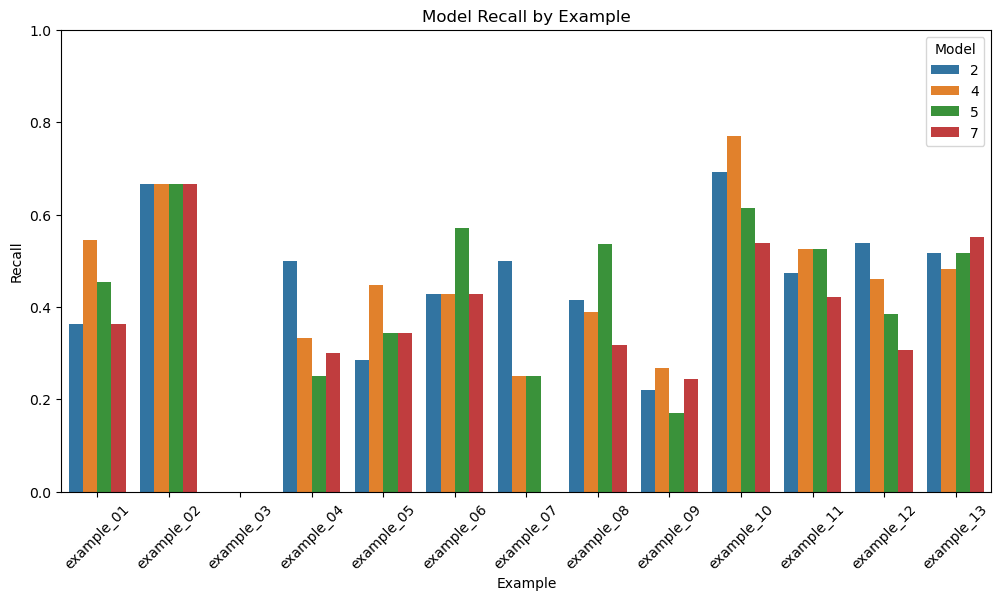

In [69]:
# matched_pairs_dict[model_name]["example_13"]["recall"]
plot_model_metrics(matched_pairs_dict, None, "mape")

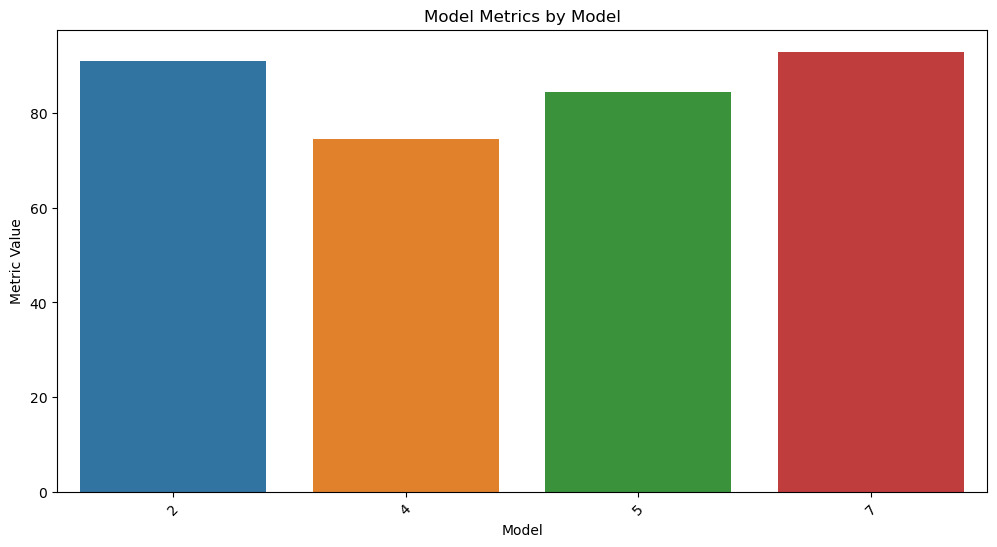

In [90]:
from eda import *
# matched_pairs_dict
# plot_model_recall_by_example(matched_pairs_dict)
# metric = None
# metric = "qty"
metric = "rowTotalCostUsd"

error_type = "mape"
x = "model"
# plot_model_metrics(matched_pairs_dict, metric, "r2")
# plot_model_metrics(matched_pairs_dict, metric, "balanced")
# plot_model_metrics(matched_pairs_dict, metric, error_type=error_type, x=x)

df_metrics = compute_model_metrics_df(matched_pairs_dict, metric=metric, error_type=error_type)
plot_model_metrics(df_metrics, x="model")

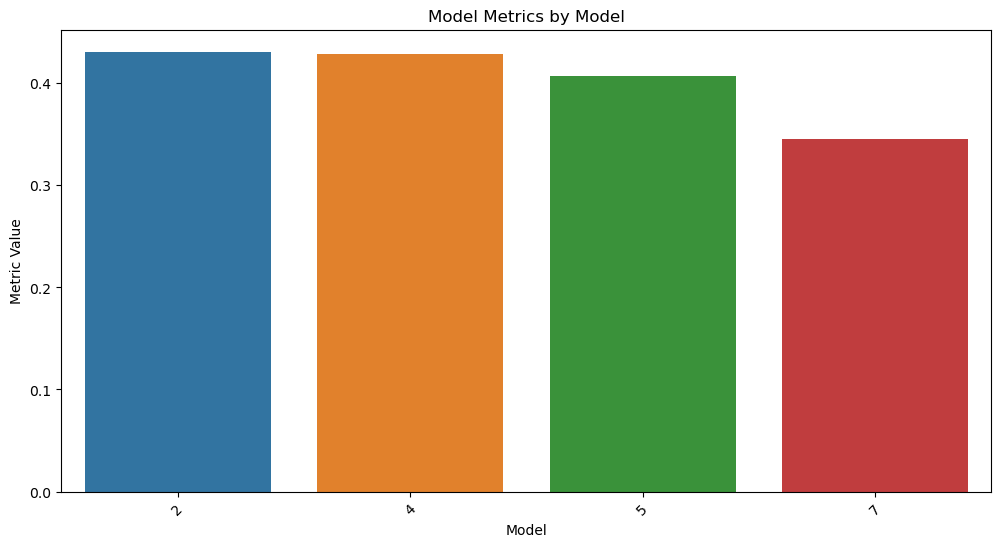

In [91]:
df_metrics = compute_model_metrics_df(matched_pairs_dict, metric=None, error_type=error_type)
plot_model_metrics(df_metrics, x="model")

In [94]:
agg_recall, _ = aggregate_by_model(df_metrics)
agg_recall

,model,value
0,2,0.430802
1,4,0.428514
2,5,0.406796
3,7,0.344893


In [ ]:
print(matched_pairs["example_01"]["recall"])
print(matched_pairs["example_02"]["recall"])
print(matched_pairs["example_03"]["recall"])
print(matched_pairs["example_04"]["recall"])
print(matched_pairs["example_05"]["recall"])
print(matched_pairs["example_06"]["recall"])
print(matched_pairs["example_07"]["recall"])
print(matched_pairs["example_08"]["recall"])
print(matched_pairs["example_09"]["recall"])
print(matched_pairs["example_10"]["recall"])
print(matched_pairs["example_11"]["recall"])
print(matched_pairs["example_12"]["recall"])
print(matched_pairs["example_13"]["recall"])

In [62]:
sorted(matched_pairs_dict["2"]["example_01"]["matched_pairs_data"].columns)

['gt_category',
 'gt_label',
 'gt_qty',
 'gt_rateUsd',
 'gt_rowTotalCostUsd',
 'gt_sectionName',
 'gt_uom',
 'justification',
 'pred_category',
 'pred_label',
 'pred_qty',
 'pred_rateUsd',
 'pred_rowTotalCostUsd',
 'pred_sectionName',
 'pred_uom',
 'similar_task']

In [64]:
# BEFORE BATCH PROCESSING LLM
matched_pairs["example_01"]["matched_pairs_data"]

,gt_label,gt_sectionName,gt_uom,gt_category,gt_qty,gt_rateUsd,gt_rowTotalCostUsd,pred_label,pred_sectionName,pred_uom,pred_category,pred_qty,pred_rateUsd,pred_rowTotalCostUsd,similar_task,justification
0,Install Toilet,Plumbing,EA,other,1.0,400.0,400.0,Toilet,Plumbing,EA,material,1.0,250.00,250.00,1,"yes, both labels refer to the task involving a..."
1,Install Wall Tile,Tile,SF,other,66.0,16.0,1056.0,Shower Wall Tile,Tile,SF,material,150.0,8.00,1200.00,1,"yes, both labels refer to a related constructi..."
2,Install Floor Tile,Tile,SF,other,73.0,16.0,1168.0,Bathroom Floor Tile,Tile,SF,material,74.0,8.00,592.00,1,"yes, both labels refer to a related constructi..."
3,Paint Ceiling - 3 Coats,Painting,SF,other,73.0,2.4,175.2,Prepare Ceiling Surfaces for Paint,Painting,SF,material,75.0,0.30,22.50,0,"no, these labels describe different stages of ..."
4,Paint Walls - 3 Coats,Painting,SF,other,288.0,2.4,691.2,Prepare Wall Surfaces for Paint,Painting,SF,material,188.0,0.30,56.40,0,"no, these labels describe different stages of ..."
5,Demo Shower Surround,Demolition,SF,other,66.0,2.4,158.4,Protect Work Area and Surroundings,Demolition,SF,labor,75.0,0.25,18.75,0,"no, these labels describe different tasks; the..."
6,Demo Vanity,Demolition,EA,other,1.0,80.0,80.0,Demo Vanity,Demolition,HRS,labor,1.0,65.00,65.00,1,"yes, the labels are identical and therefore de..."
7,Demo Tub,Demolition,EA,other,1.0,240.0,240.0,Demo Tub,Demolition,HRS,labor,2.0,65.00,130.00,1,"yes, both labels describe the exact same task ..."
8,Demo Plumbing Fixtures,Demolition,EA,other,3.0,120.0,360.0,Disposal Costs,Demolition,EA,labor plus material,1.0,400.00,400.00,0,"no, these labels do not describe the same type..."
9,Install Shower Pan,Plumbing,EA,other,1.0,520.0,520.0,Pipe Fittings and Adhesives,Plumbing,EA,material,1.0,50.00,50.00,0,"no, these labels do not describe the same type..."


In [39]:
# WITH ASYNC FUNCTIONS
print(matched_pairs["example_01"]["recall"])
print(matched_pairs["example_02"]["recall"])
print(matched_pairs["example_03"]["recall"])
print(matched_pairs["example_04"]["recall"])
print(matched_pairs["example_05"]["recall"])
print(matched_pairs["example_06"]["recall"])
print(matched_pairs["example_07"]["recall"])
print(matched_pairs["example_08"]["recall"])
print(matched_pairs["example_09"]["recall"])
print(matched_pairs["example_10"]["recall"])
print(matched_pairs["example_11"]["recall"])
print(matched_pairs["example_12"]["recall"])
print(matched_pairs["example_13"]["recall"])

0.3181818181818182
0.6666666666666666
0.0
0.5
0.2857142857142857
0.42857142857142855
0.75
0.4146341463414634
0.24390243902439024
0.6923076923076923
0.47368421052631576
0.5384615384615384
0.4827586206896552


In [73]:
print(matched_pairs["example_01"]["recall"])
print(matched_pairs["example_02"]["recall"])
print(matched_pairs["example_03"]["recall"])
print(matched_pairs["example_04"]["recall"])
print(matched_pairs["example_05"]["recall"])
print(matched_pairs["example_06"]["recall"])
print(matched_pairs["example_07"]["recall"])
print(matched_pairs["example_08"]["recall"])
print(matched_pairs["example_09"]["recall"])
print(matched_pairs["example_10"]["recall"])
print(matched_pairs["example_11"]["recall"])
print(matched_pairs["example_12"]["recall"])
print(matched_pairs["example_13"]["recall"])

# 0.36363636363636365
# 0.6666666666666666
# 0.0
# 0.5
# 0.32142857142857145
# 0.42857142857142855
# 0.5
# 0.4146341463414634
# 0.21951219512195122
# 0.6923076923076923
# 0.47368421052631576
# 0.5384615384615384
# 0.4827586206896552

0.36363636363636365
0.6666666666666666
0.0
0.5
0.32142857142857145
0.42857142857142855
0.5
0.4146341463414634
0.21951219512195122
0.6923076923076923
0.47368421052631576
0.5384615384615384
0.4827586206896552


In [71]:
matched_pairs["example_02"]["matched_pairs_data"]

,gt_label,gt_sectionName,gt_uom,gt_category,gt_qty,gt_rateUsd,gt_rowTotalCostUsd,pred_label,pred_sectionName,pred_uom,pred_category,pred_qty,pred_rateUsd,pred_rowTotalCostUsd,similar_task,justification
0,"Install Drywall at Walls: Hang, Tape, and Finish",Drywall,SF,other,200.0,2.0,400.0,1/2 inch Drywall for Walls,Drywall,SF,material,200.0,0.6,120.0,1,"yes, both labels describe the process of insta..."
1,Paint Walls - 3 Coats,Painting,SF,other,200.0,2.4,480.0,Prepare Wall Surfaces for Paint,Painting,SF,material,200.0,0.3,60.0,0,"no, these labels describe different stages of ..."
2,Insulate Walls,Insulation,SF,other,200.0,2.0,400.0,Sound Insulation Batt,Insulation,SF,material,200.0,2.5,500.0,1,"yes, both labels refer to related tasks as the..."


# Debug

### 2 output variations for each example

- It means 2 LLM
- Not the same result in each variation. Ex: one output variation contains the title "Demo Shower Pan" and the other not

In [34]:
ll = [v for v in output_02["estimate_preds"] if v["valid_file_name"] == "example_01"]

[v for v in ll[0]["rows"] if v["label"] == "Demo Shower Pan"]

[{'label': 'Demo Shower Pan',
  'qty': 2.0,
  'uom': 'HRS',
  'rateUsd': 65.0,
  'rowTotalCostUsd': 130.0,
  'category': 'labor',
  'sectionName': 'Demolition',
  'metadata': None}]

In [35]:
[v for v in ll[1]["rows"] if v["label"] == "Demo Shower Pan"]

[]

In [105]:
input_tuple = '("Demo Plumbing Fixtures", "Disposal Costs")'

compare_labels = """
# Instruction

label → Description of the specific task or item

- input: I give you a tuple (<GT LABEL>, <ESIMATE LABEL>)
- output: JSON with this format:
```json
{{
	"similar_task": <1 if they represent a similar task. 0 otherwise>
	"justification": <brief sentence to explain why>
}}
```

# Input
{input_tuple}

# Output
<COMPLETE>
"""


print(compare_labels.format(input_tuple=input_tuple))


# Instruction

label → Description of the specific task or item

- input: I give you a tuple (<GT LABEL>, <ESIMATE LABEL>)
- output: JSON with this format:
```json
{
	"similar_task": <1 if they represent a similar task. 0 otherwise>
	"justification": <brief sentence to explain why>
}
```

# Input
("Demo Plumbing Fixtures", "Disposal Costs")

# Output
<COMPLETE>

